In [1]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
import logging
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
import fastparquet
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
#medical_df['quote'] = medical_df['quote'].apply(lambda x:expand_contractions(x))

In [3]:
def full_preprocess(quote):
    quote = expand_contractions(quote)
    quote=quote.lower()
    quote=re.sub(r'\w*\d\w*','', quote)
    quote=re.sub('[%s]' % re.escape(string.punctuation), '', quote)
    quote=re.sub(' +',' ',quote)
    return quote
import string
sid = SentimentIntensityAnalyzer()


In [4]:
for year in range(8,21):
    
    for month in range(1,13):
        globals()[f'month_{month}'] = open(f'month_means/month_{year}-{month}.bz2', 'w')
        globals()['month_{:02d}_mean'.format(month)] = [0,0,0,0]

    with bz2.open('data/Quotebank/quotes-20{:02d}.json.bz2'.format(year), 'rb') as s_file:
        for index, instance in tqdm(enumerate(s_file)):
            if index%2==0:
                instance = json.loads(instance)
                quote = instance['quotation'] 
                date = instance['date'] 
                quote = full_preprocess(quote)
                vaderscore = sid.polarity_scores(quote)
                globals()['month_{}_mean'.format(date[5:7])][0]+=1
                globals()['month_{}_mean'.format(date[5:7])][1]+=vaderscore['pos']
                globals()['month_{}_mean'.format(date[5:7])][2]+=vaderscore['neg']
                globals()['month_{}_mean'.format(date[5:7])][3]+=vaderscore['compound']
    for month in range(1,13):
        for j in range(3):
            try:
                globals()[f'month_{month}'].write('{},'.format(j)+str(globals()['month_{:02d}_mean'.format(month)][j+1]/globals()['month_{:02d}_mean'.format(month)][0])+'\n')
            except:
                print("no luck, for  {} {}".format(year,month))
        globals()[f'month_{month}'].close()

13862129it [36:38, 6306.39it/s]
26611588it [1:11:37, 6192.35it/s]


In [13]:
import pandas as pd
df = pd.DataFrame(columns = ['date','pos','neg','com'])
for year in range(8,21):
    for month in range(1,13):
        f =  open(f'month_means/month_{year}-{month}.bz2', 'r').read()
        f = f.split('\n')
        try:
            df2 = {'date':'20{:02d}-{:02d}'.format(year,month), 'pos': float(f[0][2:]),'neg':float(f[1][2:]), 'com':float(f[2][2:])}
        
        
            df = df.append(df2, ignore_index = True)
        except:
            pass
        
    

In [14]:
df

,date,pos,neg,com
0,2008-09,0.118105,0.064474,0.141304
1,2008-10,0.117462,0.064832,0.140562
2,2008-11,0.120510,0.061799,0.154175
3,2008-12,0.119084,0.063045,0.146898
4,2009-01,0.119970,0.061825,0.152936
...,...,...,...,...
135,2019-12,0.124884,0.059100,0.195362
136,2020-01,0.124216,0.059956,0.191487
137,2020-02,0.124303,0.058335,0.196184
138,2020-03,0.114739,0.060681,0.164920


In [15]:
df['date'] = pd.to_datetime(df['date'],format="%Y-%m")

In [16]:
df.set_index('date', inplace=True)

Text(0.5, 0, 'Date')

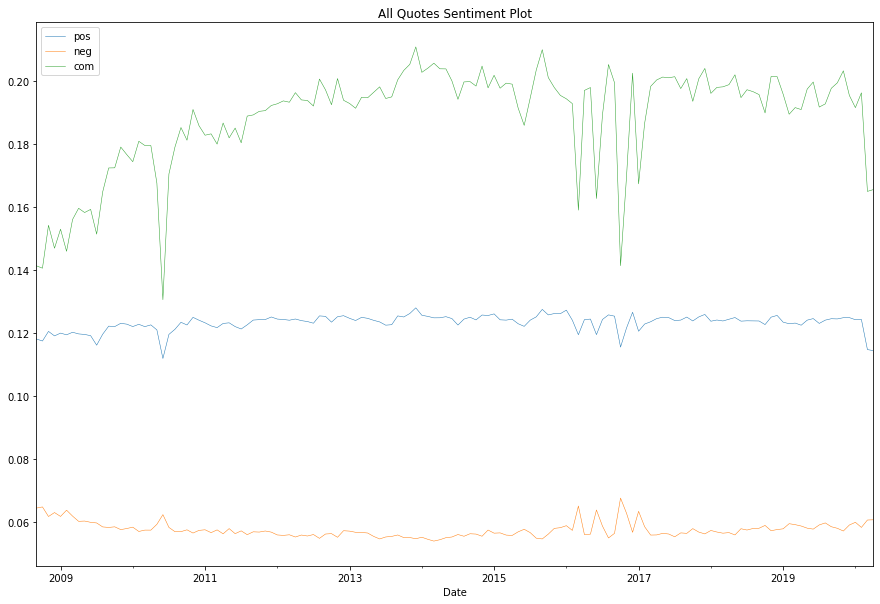

In [17]:
freq = 'M'
pos = df['pos']
neg = df['neg']
com = df['com']
com_std = df['com'].resample(freq).std()
fig, axs = plt.subplots(sharex=True,figsize=(15,10))
axs.title.set_text('All Quotes Sentiment Plot')

pos.plot(linewidth=0.5,ax = axs, label='pos')
neg.plot(linewidth=0.5,ax = axs,label='neg')
#neu.plot(linewidth=0.5,ax = axs)
com.plot(linewidth=0.5,ax = axs,label='com')
plt.legend()
plt.xlabel('Date')
